In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
from src.hyperparameter_tuner import *
from src.model_evaluation import *
from src.text_processing_utils import *
from src.viz_and_model_analysis import *

In [3]:
from collections import Counter
from wordcloud import WordCloud

In [4]:
import re

# import nltk
# nltk.download('stopwords')
# nltk.download('rslp')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [6]:
import lightgbm as lgb
import xgboost as xgb

In [7]:
raw_path = 'data/archive/'
# olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
# olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
# olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
# olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
# olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
# olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
# olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

In [8]:
# Collections for each dataset
# datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
#             olist_order_reviews, olist_products, olist_sellers]
# names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
#          'olist_order_reviews', 'olist_products', 'olist_sellers']

In [9]:
# Creating a DataFrame with useful information about all datasets
# data_info = pd.DataFrame({})
# data_info['dataset'] = names
# data_info['n_rows'] = [df.shape[0] for df in datasets]
# data_info['n_cols'] = [df.shape[1] for df in datasets]
# data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
# data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
# data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
# data_info

---

# NLP

In [10]:
olist_order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [11]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]

len(df_comments)

99224

In [13]:
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
len(df_comments)

40977

In [14]:
df_comments = df_comments.drop_duplicates(subset='review_comment_message', keep='first').reset_index(drop=True)
len(df_comments)

36159

In [15]:
df_comments.columns = ['score', 'comment']
df_comments

,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
36154,4,para este produto recebi de acordo com a compr...
36155,5,Entregou dentro do prazo. O produto chegou em ...
36156,3,"O produto não foi enviado com NF, não existe v..."
36157,5,"Excelente mochila, entrega super rápida. Super..."


In [16]:
sentiment_label = {
    1: 'negative',
    2: 'negative',
    3: 'negative',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(sentiment_label)

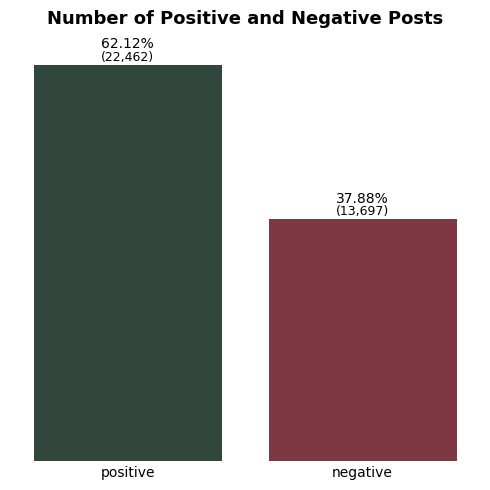

In [17]:
hue='sentiment_label'

visualizer = DataVisualizer(
    dataframe=df_comments, 
    figsize=(5, 5), 
    title = f'Number of Positive and Negative Posts'
    )

visualizer.plot_categorical_distribution(
    category_col=hue, 
    palette = ['#2e4b3a', '#8a2c3d']
    )

# Pipeline Text

In [18]:
regex_cleaner = [
    RegexCleanerTransformer.clean_line_breaks,
    RegexCleanerTransformer.clean_links,
    RegexCleanerTransformer.clean_dates,
    RegexCleanerTransformer.clean_currency,
    RegexCleanerTransformer.clean_numbers,
    RegexCleanerTransformer.clean_negations,
    RegexCleanerTransformer.clean_special_characters,
    RegexCleanerTransformer.clean_whitespace,
    RegexCleanerTransformer.clean_emojis,
    RegexCleanerTransformer.reduce_repeated_chars,
    RegexCleanerTransformer.remove_accents,
    RegexCleanerTransformer.replace_slang,
]

In [19]:
pt_stopwords = stopwords.words('portuguese')
rslp_stemmer = RSLPStemmer()

tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=6, max_df=0.7, stop_words=pt_stopwords)

In [20]:
text_pipeline = Pipeline([
    ('RegexCleanerTransformer', RegexCleanerTransformer(regex_cleaner)),
    ('StopwordRemover', StopwordRemover(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(rslp_stemmer)),
    ('TextVectorizer', TextVectorizer(tfidf_vectorizer))
])

In [21]:
review_idx = olist_order_reviews['review_comment_message'].dropna().index
review_score = olist_order_reviews['review_score'][review_idx].map(sentiment_label)

y_labels = review_score.apply(lambda x: 1 if x == 'positive' else 0).values
# y_labels = review_score.apply(lambda x: 1 if x == 'positive' else 2 if x == 'neutral' else 0).values


In [22]:
X_reviews = list(olist_order_reviews['review_comment_message'][review_idx].values)

X_processed = text_pipeline.fit_transform(X_reviews)

# fitted_vectorizer = text_pipeline.named_steps['TextVectorizer'].tfidf_vectorizer
# feature_names = fitted_vectorizer.get_feature_names_out()

In [23]:
# X = pd.DataFrame(X_processed, columns=feature_names)
# y = pd.DataFrame(y_labels, columns=['review_score'])

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_labels, random_state=42)

### Boost Hypterparametres

In [24]:
# tuner = ClassificationHyperTuner(
#     X_train=X_train, 
#     y_train=y_train, 
#     X_test=X_test,
#     y_test=y_test, 
#     model_name='lgb', 
#     use_cv=True
# )

# best_params_lgb, best_value_lgb = tuner.run_optimization()

In [25]:
best_params_lgb = {'learning_rate': 0.04182111901348278,
                   'n_estimators': 902,
                   'num_leaves': 36,
                   'max_depth': 10,
                   'min_data_in_leaf': 12,
                   'subsample': 0.7661293969659289,
                   'colsample_bytree': 0.9372152312137342,
                   'reg_alpha': 0.8440322223124193,
                   'reg_lambda': 0.01960427092078354,
                   'max_bin': 253,
                   'scale_pos_weight': 0.8664764286312472,
                   "verbose": -1}

model_lgb = lgb.LGBMClassifier(**best_params_lgb)

train_lgb = ClassificationValidator(model=model_lgb)

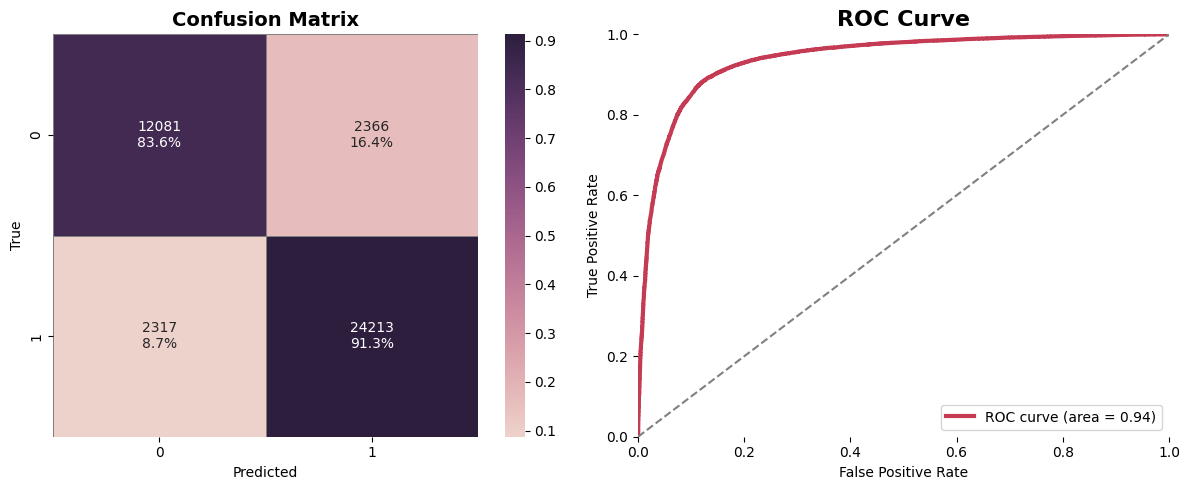

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
0,88.57,88.56,88.57,88.57,93.96,0.75,0.75,29.48


In [26]:
cross_validation_scores_lgb= train_lgb.cross_validate(X=X_processed, y=y_labels)
cross_validation_scores_lgb

In [27]:
trained_pipeline = Pipeline([
    ('RegexCleanerTransformer', RegexCleanerTransformer(regex_cleaner)),
    ('StopwordRemover', StopwordRemover(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(rslp_stemmer)),
])

trained_vectorizer = text_pipeline.named_steps['TextVectorizer'].vectorizer

trained_model = model_lgb

In [28]:
def plot_sentiment_prediction(input_text, text_pipeline, tfidf_vectorizer, classifier_model):

    if isinstance(input_text, str):
        input_text = [input_text]

    
    preprocessed_texts = text_pipeline.fit_transform(input_text)
    text_features = tfidf_vectorizer.transform(preprocessed_texts)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    X_test = pd.DataFrame(text_features.toarray(), columns=feature_names)
    
    # Predict sentiment and probability
    predictions = classifier_model.predict(X_test)
    probabilities = classifier_model.predict_proba(X_test)


    sentiment = "Positive" if predictions[0] == 1 else "Negative"
    color = "green" if sentiment == "Positive" else "red"
    
    confidence = 100 * round(probabilities[0][1 if predictions[0] == 1 else 0], 2)
    
    fig, ax = plt.subplots(figsize=(3, 1))
    
    ax.set_title(f'Sentiment Analysis: {confidence:.2f}%', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.0, sentiment, fontsize=50, ha='center', color=color)
    ax.axis('off')
    
    plt.show()

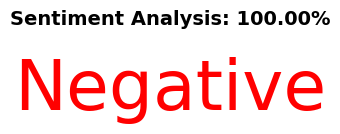

In [29]:
comment = 'Péssimo produto! Não compro nessa loja, a entrega atrasou e custou muito dinheiro!'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

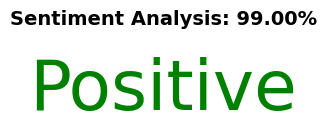

In [30]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

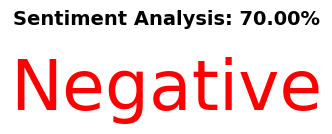

In [31]:
comment = 'Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

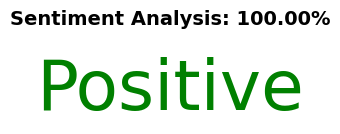

In [32]:
comment = 'Vendedor confiável, produto ok e entrega antes do prazo.'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

In [33]:
df_reviews = list(olist_order_reviews['review_comment_message'][review_idx].values)

df_processed = trained_pipeline.fit_transform(df_reviews)

fitted_vectorizer = text_pipeline.named_steps['TextVectorizer'].vectorizer
feature_names = fitted_vectorizer.get_feature_names_out()
df_complete = pd.DataFrame(df_processed, columns=['comment'])
df_complete['sentiment_label'] = df_comments['score'].map(sentiment_label)

In [34]:
positive_comments = list(df_complete.query('sentiment_label == "positive"')['comment'].values)
positive_words = ' '.join(positive_comments).split(' ')

positive_dict = Counter(positive_words)

In [35]:
negative_comments = list(df_complete.query('sentiment_label == "negative"')['comment'].values)
negative_words = ' '.join(negative_comments).split(' ')

negative_dict = Counter(negative_words)

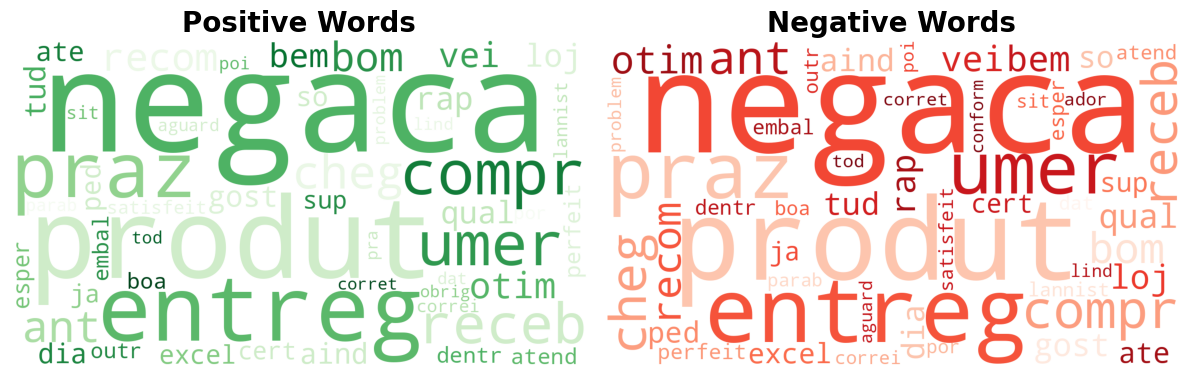

In [36]:
def generate_wordcloud(freq_dict, colormap='Greens'):
    return WordCloud(
        width=1280,
        height=720,
        collocations=False,
        random_state=42,
        colormap=colormap,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(freq_dict)

# Gerar as WordClouds
positive_wc = generate_wordcloud(positive_dict, colormap='Greens')
negative_wc = generate_wordcloud(negative_dict, colormap='Reds')

# Visualizar
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].imshow(positive_wc)
axs[0].axis('off')
axs[0].set_title('Positive Words', fontsize=20, fontweight='bold')

axs[1].imshow(negative_wc)
axs[1].axis('off')
axs[1].set_title('Negative Words', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()